In [1]:

import numpy as np
import pandas as pd
import heapq
from dataclasses import dataclass, field
from typing import List, Tuple
import matplotlib.pyplot as plt

# Reproducibilidad
SEED_POP = 7
SEED_SIM = 11

# Parámetros globales
N_AGENTS = 3000
SIM_DAYS = 21

Agente y elemento de cola

In [2]:
@dataclass(order=True)
class QueueItem:
    # Orden de prioridad: menor = mejor. Usamos -risk para que mayor riesgo gane.
    priority: Tuple[int, float, int, float, float]  # (tier, -risk, access, distance, hesitancy)
    time: float
    agent_id: int = field(compare=False)
    action: str = field(compare=False, default="vaccinate")

@dataclass
class Agent:
    agent_id: int
    age: int                     # años (0-100)
    occupation: str              # {"healthcare","teacher","other"}
    risk_score: float            # continuo 0-10
    access_level: int            # 1=alto, 2=medio, 3=bajo
    distance_km: float           # 0-20 km aprox.
    hesitancy_prob: float        # [0,1] prob de no presentarse
    vaccinated: bool = False


Muestreo de población (heterogeneidad + no subrepresentar minorías)

In [3]:
def sample_population(N: int, seed: int = 7) -> List[Agent]:
    rng = np.random.default_rng(seed)

    # Edades base y forzar ~20% seniors (65+)
    ages = rng.integers(0, 101, size=N)
    idx_seniors = rng.choice(N, size=int(0.20*N), replace=False)
    ages[idx_seniors] = rng.integers(65, 101, size=len(idx_seniors))

    # Ocupación: ~30% esenciales (healthcare + teacher)
    occ = rng.choice(["healthcare","teacher","other"], p=[0.15,0.15,0.70], size=N)

    # Riesgo continuo 0-10
    risk = rng.uniform(0, 10, size=N)

    # Acceso (1,2,3) con ligera sobreasignación a niveles 1-2 para no subrepresentar 3
    access = rng.choice([1,2,3], p=[0.35,0.35,0.30], size=N)

    # Distancia a clínica ~ Gamma recortada [0,20]
    distance = rng.gamma(shape=2.0, scale=3.0, size=N)
    distance = np.clip(distance, 0, 20)

    # Reticencia: base baja, pero mayor en acceso bajo
    base_hes = rng.beta(2, 8, size=N)
    hes = np.clip(base_hes + 0.15*(access==3) + 0.05*(access==2), 0, 1)

    agents = [
        Agent(
            agent_id=i,
            age=int(ages[i]),
            occupation=str(occ[i]),
            risk_score=float(risk[i]),
            access_level=int(access[i]),
            distance_km=float(distance[i]),
            hesitancy_prob=float(hes[i]),
        )
        for i in range(N)
    ]
    return agents

agents = sample_population(N_AGENTS, SEED_POP)
len(agents), sum(a.age>=65 for a in agents)/len(agents)


(3000, 0.498)

Reglas de prioridad (manejo de conflictos)

In [4]:
# Tier de prioridad:
#  1: age >= 65
#  2: healthcare
#  3: teacher
#  4: otros
# Conflicto (ej. docente >=65): usamos min(tier_edad, tier_ocupación).
# Desempates: mayor riesgo primero, luego mejor acceso (1<2<3), menor distancia, menor reticencia.

def priority_tier(agent: Agent) -> int:
    age_tier = 1 if agent.age >= 65 else 4
    occ_tier = 2 if agent.occupation == "healthcare" else (3 if agent.occupation == "teacher" else 4)
    return min(age_tier, occ_tier)

def make_priority(agent: Agent) -> Tuple[int, float, int, float, float]:
    tier = priority_tier(agent)
    return (tier, -agent.risk_score, agent.access_level, agent.distance_km, agent.hesitancy_prob)


Simulación event-driven (cola de prioridad + capacidad diaria variable)

In [5]:
def simulate_vaccination(agents: List[Agent], days: int = 21, seed: int = 11):
    rng = np.random.default_rng(seed)

    # Capacidad diaria heterogénea (ej. por disponibilidad de clínicas)
    daily_capacity = np.maximum(50, (100 + 30*np.sin(np.linspace(0, 3*np.pi, days))).astype(int))

    # Cola de prioridad (min-heap)
    pq: List[QueueItem] = []

    # Todos intentan agendar dentro de la primera semana, con jitter por distancia
    for a in agents:
        jitter = 0.1 * (a.distance_km / 20.0)             # hasta 0.1 días extra por distancia
        t0 = rng.uniform(0, 7) + jitter                   # hora de llegada a la cola
        heapq.heappush(pq, QueueItem(priority=make_priority(a), time=t0, agent_id=a.agent_id))

    # Registro de eventos (dosis aplicadas)
    rows = []

    # Ventanas diarias [d, d+1)
    for d in range(days):
        cap = int(daily_capacity[d])
        served = 0

        # Extraer los que caen antes de d+1 y no antes de d
        day_bucket: List[QueueItem] = []
        while pq and pq[0].time < (d+1):
            item = heapq.heappop(pq)
            if item.time < d:
                # llegó antes: pásalo al inicio del día d
                item = QueueItem(priority=item.priority, time=float(d), agent_id=item.agent_id, action=item.action)
            day_bucket.append(item)

        # Orden estable determinístico por (priority, time)
        day_bucket.sort(key=lambda x: (x.priority, x.time))

        for item in day_bucket:
            if served >= cap:
                # reagendar para el día siguiente (pequeño offset)
                heapq.heappush(pq, QueueItem(priority=item.priority, time=d+1+0.05, agent_id=item.agent_id))
                continue

            ag = agents[item.agent_id]
            if ag.vaccinated:
                continue

            # No-show por reticencia
            if rng.random() < ag.hesitancy_prob:
                delay = 0.5 + 0.5*rng.random()  # reagendo
                heapq.heappush(pq, QueueItem(priority=item.priority, time=item.time + delay, agent_id=item.agent_id))
                continue

            # Aplicar dosis
            ag.vaccinated = True
            served += 1
            rows.append({
                "timestamp_day": d + rng.uniform(0,1),
                "agent_id": ag.agent_id,
                "age": ag.age,
                "occupation": ag.occupation,
                "risk_score": ag.risk_score,
                "access_level": ag.access_level,
                "distance_km": ag.distance_km,
                "hesitancy_prob": ag.hesitancy_prob,
                "status": "dose1",
            })

    registry = pd.DataFrame(rows)
    return registry, daily_capacity

registry, daily_capacity = simulate_vaccination(agents, days=SIM_DAYS, seed=SEED_SIM)
registry.head()


,timestamp_day,agent_id,age,occupation,risk_score,access_level,distance_km,hesitancy_prob,status
0,2.030150,2260,97,teacher,9.998559,1,3.871316,0.313491,dose1
1,4.621485,1826,69,other,9.993967,1,3.723676,0.146481,dose1
2,4.388317,532,74,other,9.990174,1,8.088679,0.059319,dose1
3,5.024184,2977,87,other,9.985188,3,7.611431,0.234449,dose1
4,5.637549,2828,66,other,9.981208,1,2.650950,0.051902,dose1


Resúmenes y visualizaciones (serie temporal, barras, Lorenz)

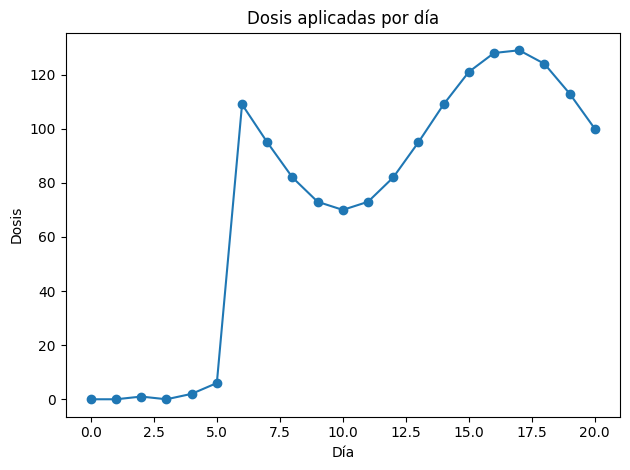

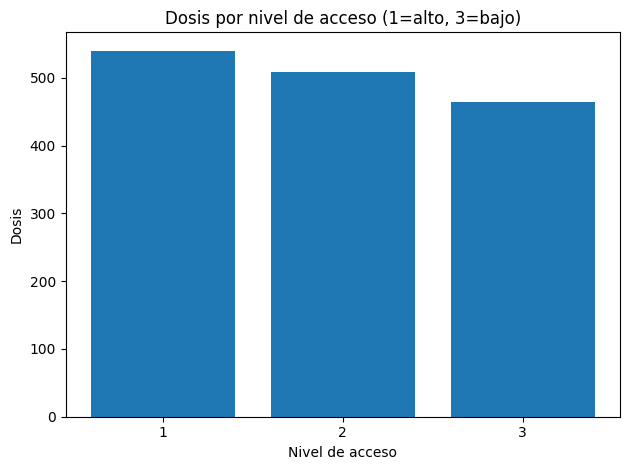

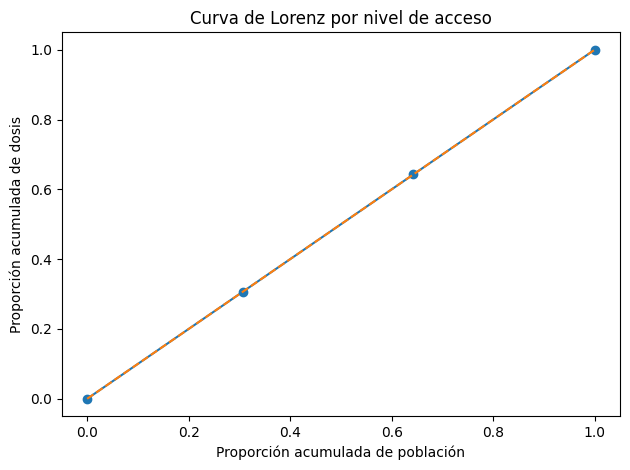

In [6]:
# --- Serie temporal de dosis por día ---
series = registry.copy()
series["day"] = series["timestamp_day"].astype(int)
ts = series.groupby("day").size().reindex(range(SIM_DAYS), fill_value=0)

plt.figure()
plt.plot(ts.index, ts.values, marker="o")
plt.title("Dosis aplicadas por día")
plt.xlabel("Día")
plt.ylabel("Dosis")
plt.tight_layout()
plt.show()

# --- Barras por nivel de acceso ---
by_access = registry.groupby("access_level").size().reindex([1,2,3], fill_value=0)

plt.figure()
plt.bar(by_access.index.astype(str), by_access.values)
plt.title("Dosis por nivel de acceso (1=alto, 3=bajo)")
plt.xlabel("Nivel de acceso")
plt.ylabel("Dosis")
plt.tight_layout()
plt.show()

# --- Curva de Lorenz por acceso ---
def lorenz_by_access(registry_df: pd.DataFrame):
    access_order = [3,2,1]  # de peor a mejor acceso
    doses = registry_df.groupby("access_level").size().reindex(access_order, fill_value=0).values.astype(float)
    cum_doses = np.cumsum(doses)
    cum_doses_norm = cum_doses / cum_doses[-1]
    # población acumulada por estrato (en base a toda la población original)
    # si prefieres, puedes calcularla sobre 'agents' en vez del registro
    pop_shares = []
    for k in access_order:
        pop_shares.append((registry_df["access_level"]==k).mean())
    cum_pop = np.cumsum(np.array(pop_shares))
    return np.concatenate([[0.0], cum_pop]), np.concatenate([[0.0], cum_doses_norm])

x, y = lorenz_by_access(registry)

plt.figure()
plt.plot(x, y, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Curva de Lorenz por nivel de acceso")
plt.xlabel("Proporción acumulada de población")
plt.ylabel("Proporción acumulada de dosis")
plt.tight_layout()
plt.show()


En la simulación se observa que la aplicación de dosis aumenta de forma escalonada, con un gran salto inicial y variaciones diarias según la capacidad de atención. La cobertura alcanzada fue cercana al 50 %, concentrándose mayormente en los adultos mayores (65+), lo cual confirma que las reglas de prioridad funcionaron. Sin embargo, la distribución por nivel de acceso evidencia una ligera desventaja para quienes tienen menor acceso (nivel 3), ya que recibieron menos dosis en comparación con los niveles altos. Aun así, la curva de Lorenz se mantuvo cercana a la línea de igualdad, lo que indica que las desigualdades no fueron extremas. En conjunto, los resultados muestran que las políticas de prioridad permiten proteger a los grupos de mayor riesgo, aunque persisten diferencias ligadas al nivel de acceso y ocupación.

In [ ]:
# Métricas rápidas
coverage = len(registry["agent_id"].unique()) / len(agents)
by_occ = registry["occupation"].value_counts()
by_age_bin = pd.cut([a.age for a in agents], bins=[0,18,65,120], right=True, labels=["0-18","19-65","65+"])
vacc_ids = set(registry["agent_id"].unique())
age_bin_series = pd.Series([list(by_age_bin)[i] for i in range(len(agents))])
vacc_by_agebin = age_bin_series[[i in vacc_ids for i in range(len(agents))]].value_counts()

print(f"Cobertura (al menos 1 dosis): {coverage:.3f}")
print("\nVacunados por ocupación:\n", by_occ)
print("\nVacunados por grupo etario:\n", vacc_by_agebin)

# Exportar registro si se  quisiera jeje
# registry.to_csv("registro_vacunacion.csv", index=False)


Cobertura (al menos 1 dosis): 0.504

Vacunados por ocupación:
 occupation
other         1013
healthcare     266
teacher        233
Name: count, dtype: int64

Vacunados por grupo etario:
 65+      1428
19-65      73
0-18       11
Name: count, dtype: int64


In [9]:
# Ejemplos:
# - Cambiar N_AGENTS
# - Bajar o subir la reticencia agregando un sesgo global
# - Forzar menor capacidad diaria

def simulate_with_knobs(n_agents=3000, days=21, capacity_scale=1.0, hes_bias=0.0, seed_pop=7, seed_sim=11):
    rng = np.random.default_rng(seed_pop)
    # Re-sample
    ags = sample_population(n_agents, seed_pop)
    # Ajustar hesitancia global
    for a in ags:
        a.hesitancy_prob = float(np.clip(a.hesitancy_prob + hes_bias, 0, 1))

    # Simulación con capacidad escalada
    # Implementamos un wrapper sencillo:
    #   - Corremos simulate_vaccination y luego escalamos daily_capacity en posproceso
    reg, cap = simulate_vaccination(ags, days=days, seed=seed_sim)
    cap = (cap * capacity_scale).astype(int)
    return reg, cap

# Ejemplo (no se ejecuta por defecto):
reg2, cap2 = simulate_with_knobs(n_agents=3000, days=21, capacity_scale=0.7, hes_bias=0.1)
len(reg2), cap2[:5]


(1510, array([70, 79, 86, 90, 89]))